# Random Walk & Random Walk with Restart

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal

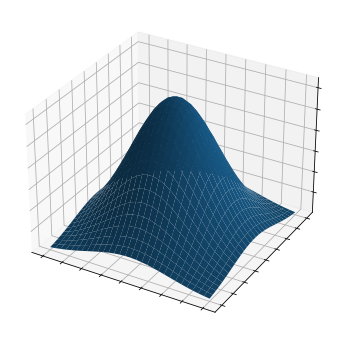

In [2]:
x, y = np.mgrid[-1.0:1.0:30j, -1.0:1.0:30j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])

mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)

fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x,y,z)
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

#ax.plot_wireframe(x,y,z)

plt.show()

### Random Walk Implementation

In [5]:
import random

In [6]:
class Location(object):
    def __init__(self, x, y):
        '''
        Immutable object
        x (Float)
        y (Float)
        '''
        self.x = x
        self.y = y
        
    def move(self, deltaX, deltaY):
        '''
        deltaX (Float)
        deltaY (Float)
        
        Returns the new locationn
        '''
        return Location(self.x + deltaX, self.y + deltaY)
    
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def distFrom(self, other):
        xDist = self.x - other.getX()
        yDist = self.y - other.getY()
        return (xDist ** 2 + yDist **2)**0.5
    
    def __str__(self):
        return '<' + str(self.x) + ', ' + str(self.y) + '>'
        

In [7]:
class Drunk(object):
    def __init__(self, name = None):
        '''
        Base class -- will be inherited by other sub classes
        name (String)
        '''
        self.name = name
        
    def __str__(self):
        if self != None:
            return self.name
        return 'Anonymous'

In [8]:
class UsualDrunk(Drunk):
    def takeStep(self):
        step_choices = [(1,0), (0,1), (-1,0), (0, -1)]
        return random.choice(step_choices)
    
def NorthDrunk(Drunk):
    def takeStep(self):
        step_choices = [(0.0, 1.1), (0.0, -0.9), (1.0, 0.0), (-1.0, 0.0)]
        return random.choice(step_choices)


In [23]:
class Field(object):
    def __init__(self):
        self.drunks = {}
        
    def addDrunk(self, drunk, loc):
        if drunk in self.drunks:
            raise ValueError('Duplicate Drunks')
        else:
            self.drunks[drunk] = loc
            
    def getLoc(self, drunk):
        if drunk not in self.drunks:
            raise ValueError('Drunk not found')
        return self.drunks[drunk]
    
    def moveDrunk(self, drunk):
        if drunk not in self.drunks:
            raise ValueError('Drunk not found')
        xDist, yDist = drunk.takeStep()
        
        # use move method to get new location
        self.drunks[drunk] = self.drunks[drunk].move(xDist, yDist)

In [11]:
def walk(f, d, num_steps):
    '''
    f (Field)
    d (Drunk in f)
    num_steps (Integer >= 0)
    
    Moves d num_steps times, returns the distance from final locaiton and locaiton at origin
    '''
    start = f.getLoc(d)
    for s in range(num_steps):
        f.moveDrunk(d)
    return start.distFrom(f.getLoc(d))

In [25]:
def simWalks(num_steps, num_trials, dClass):
    
    Homer = dClass()
    origin = Location(0,0)
    distances = []
    for t in range(num_trials):
        f = Field()
        f.addDrunk(Homer, origin)
        distances.append(round(walk(f, Homer, num_steps), 1))
    
    return distances

In [14]:
def DrunkTest(walkLengths, num_trials, dClass):
    
    for num_steps in walkLengths:
        distances = simWalks(num_steps, num_trials, dClass)
        print(dClass.__name__, 'random walk of ', num_steps, 'steps')
        print('Mean ', round(sum(distances) / len(distances)), 4)
        print('Max ', max(distances), 'Min ', min(distances))

In [27]:
DrunkTest((10, 100, 1000), 100, UsualDrunk)

UsualDrunk random walk of  10 steps
Mean  3 4
Max  6.3 Min  0.0
UsualDrunk random walk of  100 steps
Mean  9 4
Max  24.0 Min  0.0
UsualDrunk random walk of  1000 steps
Mean  28 4
Max  75.6 Min  4.5


### Random Walk with Restart Implementation

In [1]:
import numpy as np
import networkx as nx
import random
import pandas as pd

from scipy.sparse import spdiags
from functools import partial

In [2]:
def rwr(x, T, R = 0.2, max_iters = 100):
    '''
    This function will perform the random walk with restart algorithm on a given vector x and the associated
    transition matrix of the network
    
    args:
        x (Array) : Initial vector
        T (Matrix) : Input matrix of transition probabilities
        R (Float) : Restart probabilities
        max_iters (Integer) : The maximum number of iterations
        
    returns:
        This function will return the result vector x
    '''
    
    old_x = x
    err = 1.
    
    for i in range(max_iters):
        x = (1 - R) * (T.dot(old_x)) + (R * x)
        err = np.linalg.norm(x - old_x, 1)
        if err <= 1e-6:
            break
        old_x = x
    return x

In [18]:
def run_rwr(g, R, max_iters):
    '''
    This function will run the `rwr` on a network
    
    args:
        g (Network) : This is a networkx network you want to run rwr on
        R (Float) : The restart probability
        max_iters (Integer) : The maximum number of iterations
        
    returns:
        This fuunction will return a numpy array of affinities where each element in the array will represent
        the similarity between two nodes
    '''
    
    A = nx.adjacency_matrix(g, weight = 'weight')
    m,n = A.shape
    
    d = A.sum(axis = 1)
    d = np.asarray(d).flatten(())
    d = np.maximum(d, np.ones(n))
    
    invd = spdiags(1.0 / d, 0, m, n)
    T = invd.dot(A)
    
    rwr_fn = partial(rwr, T = T, R = R, max_iters = max_iters)
    
    aff = [rwr_fn(x) for x in np.identity(m)]
    aff = np.array(aff)
    return aff

In [22]:
if __name__ == '__main__':
    # for simplicity let's use a fully connected graph and randomly remove edges from it
    n, n_remove = 40, 250

    G = nx.Graph()
    G.add_nodes_from(range(n))
    G = nx.complete_graph(n, create_using=G)
    remove = random.sample(G.edges(),k=n_remove)
    G.remove_edges_from(remove)
    
    # apply random walk with restart on this network
    aff = run_rwr(G, R = 0.2, max_iters=1000)
    
    # convert into df where index and columns are nodes and each row value is the similarity between the two nodes
    aff_df = pd.DataFrame(
        aff,
        index = G.nodes(),
        columns = G.nodes()
    )

In [4]:
def gnp_random_connected_graph(n, p):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    
    Source : https://stackoverflow.com/questions/61958360/how-to-create-random-graph-where-each-node-has-at-least-1-edge-using-networkx
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [5]:
from itertools import combinations, groupby

nodes = random.randint(5,10)
seed = random.randint(1,10)
probability = 0.1
G = gnp_random_connected_graph(nodes,probability)

In [6]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 8
Average degree:   2.2857
